## GlADE+ catalog visualization

In this notebook, we use the `healpy` library to visualize the data output from the `parse_catalog` script. We follow the tutorial provided in the [`healpy` documentation](https://healpy.readthedocs.io/en/latest/tutorial.html).

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import healpy as hp

from catalog.utils import GalaxyCatalog

In [52]:
# Constants
nside = 32
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        nside, hp.nside2resol(nside, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 32 is 1.8 deg


In [53]:
filename = "GLADE+reduced.txt"
# Uncomment to parse raw catalog file. May take some time
#%run -i -t parse_catalog.py {filename}  -v --nside {nside}

Number of pixels in the map:

In [54]:
npix = hp.nside2npix(nside)
npix

12288

Importing file:

In [55]:
catalog = GalaxyCatalog('catalog/output.hdf5')

The `skymap` dataset holds the corresponding pixel for each galaxy. In the cell below, we convert this information into an array of length `npix` holding the number of galaxies within each pixel:

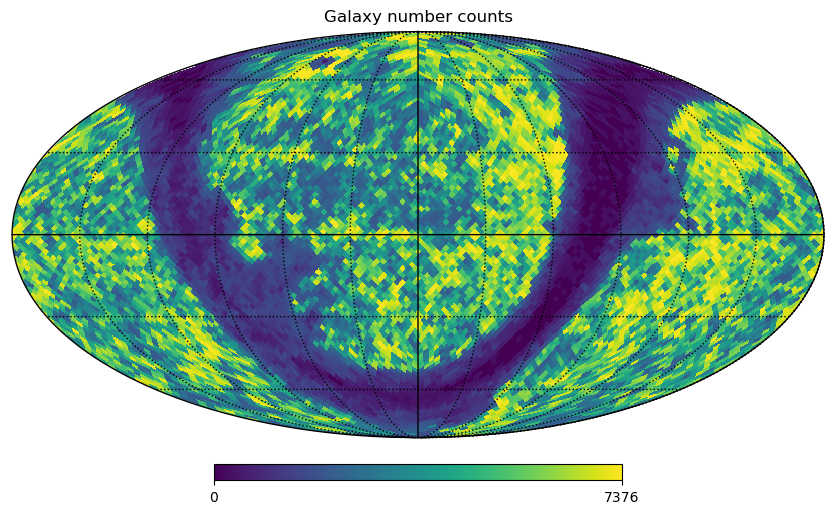

In [56]:
skymap_indices = catalog.skymap
nonempty_pixels, counts = np.unique(skymap_indices, return_counts=True)
skymap = np.zeros(npix)
for pixel, count in zip(nonempty_pixels, counts):
    skymap[pixel] = count
hp.mollview(skymap, title="Galaxy number counts", norm="hist")
hp.graticule()
plt.savefig('figures/galaxy-map.png', dpi=400)
plt.show()

Histogram of the redshift distribution:

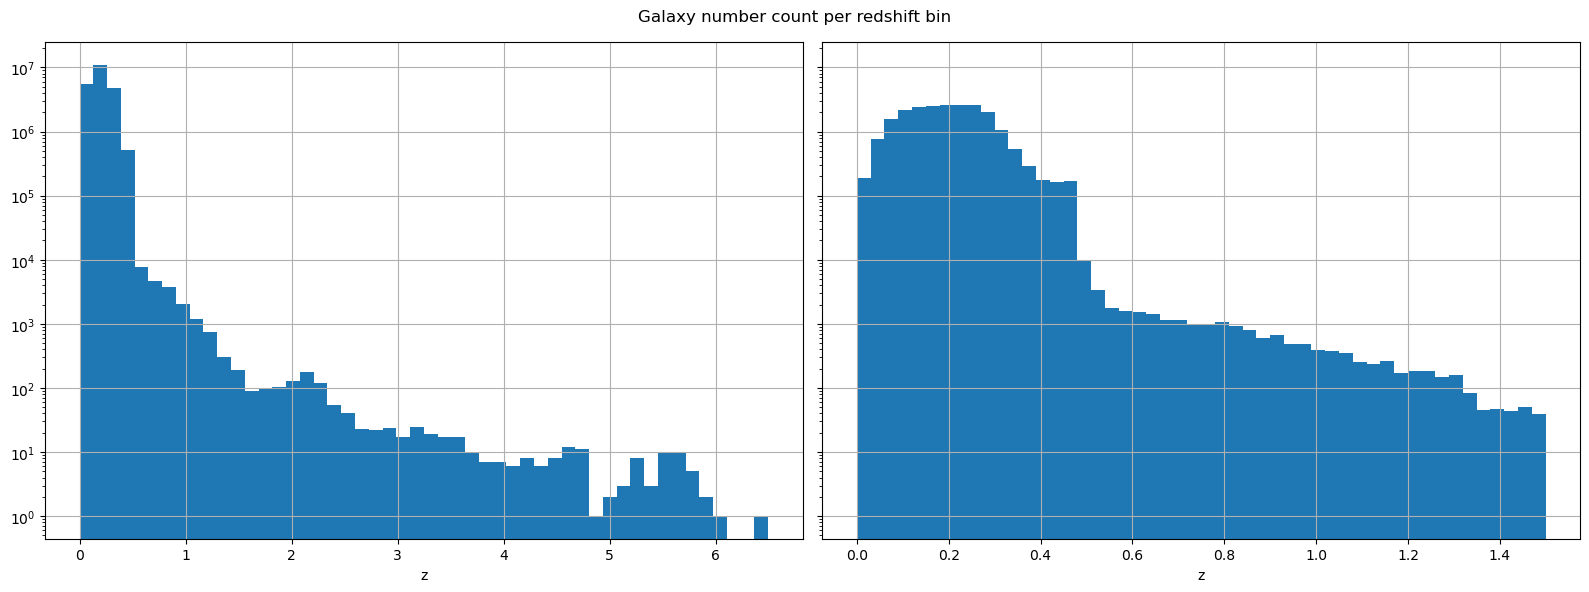

In [61]:
z = catalog.z
z_max = 1.5
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
ax1.hist(z, bins=50, log=True)
ax2.hist(z[z < z_max], bins=50, log=True)
ax1.set_xlabel('z')
ax2.set_xlabel('z')
ax1.grid()
ax2.grid()
fig.suptitle('Galaxy number count per redshift bin')
plt.subplots_adjust(wspace=0.1, hspace=0)
fig.tight_layout()
fig.savefig('figures/galaxy-redshift-distribution.png', dpi=400)
plt.show()

Mergers within galaxies at $z > 1.5$ are very unlikely to be detected by current-generation detectors. Let us repeat the plot upt to $z_{\text{max}}=1.5$:

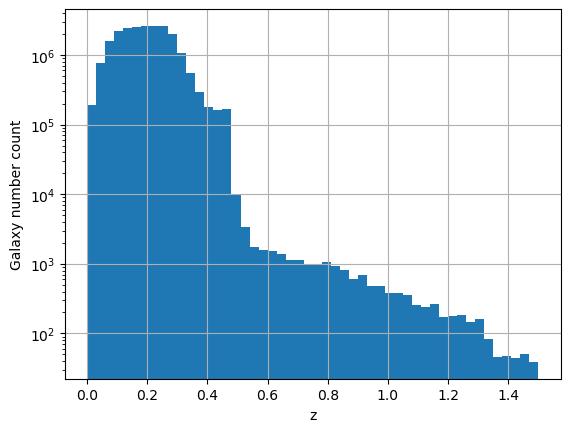

In [58]:
z = catalog.z
plt.hist(z[z < 1.5], bins=50, log=True)
plt.xlabel('z')
plt.ylabel('Galaxy number count')
plt.grid()
plt.show()

In [59]:
catalog.close()